In [ ]:
"""
This file shows how Schrodingersation method works for heat equation.
We would like to solve the following problem:

∂u/∂t = a ∂^2u/∂x^2      (t,x) ∈ [0, T] , [left_x, right_x]
u(0,x) = sin(2πx / (right_x - left_x))

coefficient a is chosen as:
a = (right_x - left_x) / (2π)^2

This heat equation's analytic solution is:
u(t,x) = exp(-t/(right_x - left_x)) · sin(2πx / (right_x - left_x))
"""

"\nThis file shows how Schrodingersation method works for heat equation.\nWe would like to solve the following problem:\n\n∂u/∂t = a ∂^2u/∂x^2      (t,x) ∈ [0, T] × [left_x, right_x]\nu(0,x) = sin(2πx / (right_x - left_x))\n\ncoefficient a is chosen as:\na = (right_x - left_x) / (2π)^2\n\nThis heat equation's analytic solution is:\nu(t,x) = exp(-t/(right_x - left_x)) × sin(2πx / (right_x - left_x))\n"

In [5]:
import numpy as np
n_x = 5    # Number of qubits for spatial variable x
n_p = 9    # Number of qubits for Schrodingersation variable p
N_p = 2 ** n_p
left_x = 0
right_x = 15
R = 10    # The computational domain for Schrodingersation variable p is p ∈ [-2πR, 2πR]
t = 5     # Evolution time
a = (right_x - left_x) / (2*np.pi)**2

In [6]:
def generate_compact_p_2_normal(n, a, b):
    # This function create the finite difference matrix for the second order derivative with periodic boundary condition
    # The size of the matrix is 2^n x 2^n
    size = 2 ** n
    # Create a zero matrix of the specified size with a complex data type
    matrix = np.zeros((size, size), dtype=np.complex128)
    # Set the off-diagonal elements
    np.fill_diagonal(matrix[1:], 1)
    np.fill_diagonal(matrix[:, 1:], 1)
    # Set the diagonal elements
    np.fill_diagonal(matrix, -2)
    # Set the corner elements to complete the specified structure
    matrix[0, -1] = 1
    matrix[-1, 0] = 1

    delta_z = (b - a) / 2 ** n  # grid size
    matrix = matrix / delta_z**2
    return matrix

In [9]:
# Create Hamiltonian for the obtained Schrodinger equation

from scipy import sparse as sp
eta = np.arange(N_p)     # [0, 1, 2, ..., N_p-1]
eta[N_p // 2 : ] -= N_p  # Shift to [0, 1, 2, ..., N_p/2 -1, -N_p/2, -N_p/2 +1, ..., -1] (For indices from the halfway point to the end, subtract N_p)
                         # for example, if N_p = 8, eta becomes [0, 1, 2, 3, -4, -3, -2, -1]
eta = eta / R            # Scale to [-2πR, 2πR]
                         # for example, if R = 10, eta becomes [0, 0.1, 0.2, 0.3, -0.4, -0.3, -0.2, -0.1]
eta = sp.diags(eta)      # Create a diagonal sparse matrix from the eta array


p_2 = sp.csr_matrix(generate_compact_p_2_normal(n_x, left_x, right_x)) # Finite difference matrix for the second order derivative with periodic boundary condition
                                                                       # csr_matrix is a compressed sparse row matrix, which is more efficient for arithmetic operations and matrix-vector products
                                                                       # The size of p_2 is 2^n_x x 2^n
matrix = sp.csr_matrix(sp.kron(p_2, eta))

In [16]:
# create initial state
p_state = np.exp(- np.abs(np.arange(-R * np.pi, R * np.pi, step = 2 * R * np.pi / N_p)))
eta_state = np.fft.ifft(p_state)

u_state = np.linspace(left_x, right_x, 2**n_x + 1)
u_state = (np.sin(2 * np.pi * u_state[:-1] / (right_x - left_x)))

initial_state = np.kron(u_state, eta_state)

In [21]:
from scipy.sparse.linalg import expm_multiply
finial_state = expm_multiply(1j * matrix * t * a, initial_state)


In [22]:
finial_state2 = finial_state.reshape((2**n_x, 2**n_p))
finial_state3 = np.fft.fft(finial_state2, axis=1)

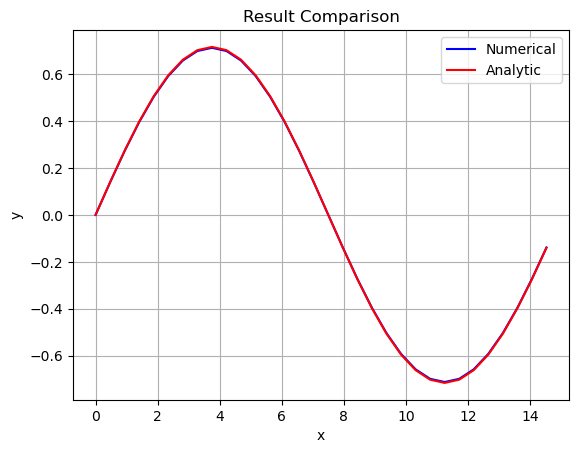

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(left_x, right_x, 2**n_x + 1) 
x = x[:-1]


k = N_p // 2 + 1   # Select which p_j to recover solution
y = finial_state3[:, k] / p_state[k ] # numerical
y2 = np.exp(-t/(right_x - left_x)) * np.sin(2 * np.pi * x / (right_x - left_x)) # analytic 


# 在同一张图上绘制 y 和 y2
plt.plot(x, y.real, label='Numerical', color='b')  # 绘制 y
plt.plot(x, y2.real, label='Analytic', color='r')  # 绘制 y2
# plt.plot(x, y3.real, label='Analytic2', color='g')  # 绘制 y2

# 设置标签和标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Result Comparison')

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 显示图像
plt.show()